# 一、骨架分解

## 1.Murcko Scaffold
Murcko骨架由Murcko等人设计并用药物的形状、结构分析。他们将药物分子拆解成四种单元：环系结构（ring system）、接头（linker）、骨架（scaffold）、侧链（side chain），其中scaffold又由ring system和linker组成；scaffold和side chain又组成了药物分子。这么拆解可以提供以下几点好处：
1. Scaffold可以为药物的整体设计提供参考
2. Ring system和linker可以为药化提供合成单元
3. 可以通过形状的分析，评价分子库的类药程度

Rdkit中也提供了一些用于骨架和侧链分析的工具
- 获取Murcko骨架：GetScaffoldForMol()

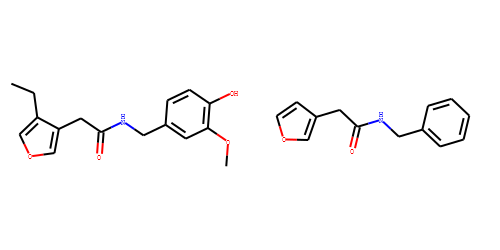

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
m = Chem.MolFromSmiles('O=C(NCc1cc(OC)c(O)cc1)Cc1cocc1CC')
core = MurckoScaffold.GetScaffoldForMol(m)
m_core = [m, core]
img = Draw.MolsToGridImage(m_core, subImgSize=(250, 250), molsPerRow=2)
img

In [2]:
img.save('data/scaffold_sidechain_dec_1.png')

 - 直接获取smiles的murcko骨架，并输出smiles：MurckoScaffoldSmilesFromSmiles(smiles, mol, includeChirality)
 - 同MurckoScaffoldSmiles()

In [3]:
MurckoScaffold.MurckoScaffoldSmilesFromSmiles('O=C(NCc1cc(OC)c(O)cc1)Cc1cocc1CC')

'O=C(Cc1ccoc1)NCc1ccccc1'

## 2.Generic Framework

将分子以图的形式表示，对结构进行抽象，即所有的原子作为顶点，所有的键作为边，主要反映了原子间的连接属性。
 - 产生generic骨架：MakeScaffoldGeneric()<br />
所有重原子都以碳来代替，所有的键都以单键代替

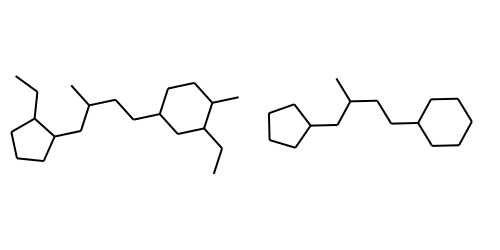

In [4]:
gen_mcore = map(MurckoScaffold.MakeScaffoldGeneric, m_core)
img = Draw.MolsToGridImage(list(gen_mcore), molsPerRow=2, subImgSize=(250, 250))
img

In [5]:
img.save('data/scaffold_sidechain_dec_2.png')

# 二、侧链分离

## 1.rdRGroupDecomposition
 - 先读进来一组分子
 - 定义一个母核，并指定侧链位置。
 - 也可以不标注侧链的序号，系统会自动生成序号

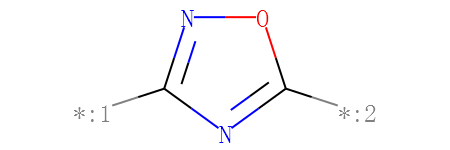

In [6]:
import os
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit.Chem import RDConfig
fName = os.path.join(RDConfig.RDDocsDir, 'Book\\data\\s1p_chembldoc89753.txt')
suppl = Chem.SmilesMolSupplier(fName, delimiter=",", smilesColumn=9, nameColumn=10)
ms = [x for x in suppl if x]
core = Chem.MolFromSmiles('[*:1]c1nc([*:2])on1')
core

In [7]:
Draw.MolToFile(core, 'data/scaffold_sidechain_dec_3.png', size=(200, 200))

 - rdRGD.RGroupDecompose(cores, mols, asSmiles , ...)<br />
 cores：母核<br />
 mols：要拆解的分子<br />
 asSmiles：返回smiles还是mol对象<br />
 - 变量unmatched用来存放没有匹配上母核的分子
 - 变量res是一个字典的列表，每个字典对应一个分子匹配上的母核和的侧链。

In [8]:
res, unmatched = rdRGD.RGroupDecompose([core], ms, asSmiles=True)
print(len(res), len(unmatched))
res[0]

40 0


{'Core': 'n1oc([*:2])nc1[*:1]',
 'R1': 'O=C(O)CCCC1NCCOc2c1cccc2[*:1]',
 'R2': 'CC(C)Oc1ccc([*:2])cc1Cl'}

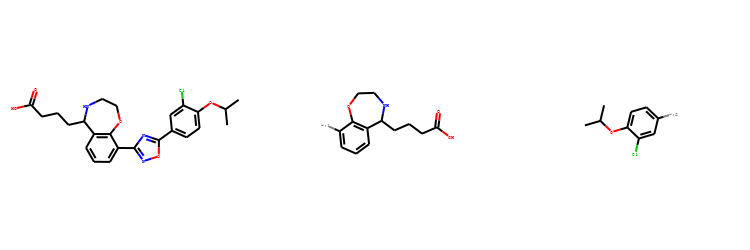

In [9]:
img = Chem.Draw.MolsToGridImage([ms[0], Chem.MolFromSmiles(res[0]['R1']), Chem.MolFromSmiles(res[0]['R2'])], molsPerRow=3, subImgSize=(250, 250))
img

In [10]:
img.save('data/scaffold_sidechain_dec_4.png')

 - 还可以直接将res结果转换成dataframe

In [11]:
import pandas as pd
df = pd.DataFrame(res)
df.head()

,Core,R1,R2
0,n1oc([*:2])nc1[*:1],O=C(O)CCCC1NCCOc2c1cccc2[*:1],CC(C)Oc1ccc([*:2])cc1Cl
1,n1oc([*:2])nc1[*:1],O=C(O)CCC1NCCOc2c1cccc2[*:1],CC(C)Oc1ccc([*:2])cc1Cl
2,n1oc([*:2])nc1[*:1],O=C(O)CCC1COc2ccc([*:1])cc2CN1,CC(C)Oc1ccc([*:2])cc1Cl
3,n1oc([*:2])nc1[*:1],O=C(O)CCCC1NCCOc2c1cccc2[*:1],CC(C)Oc1ncc([*:2])cc1Cl
4,n1oc([*:2])nc1[*:1],O=C(O)CCCC1NCCOc2c1cccc2[*:1],CC(C)Oc1ncc([*:2])cc1Cl


## 2.ReplaceCore
除了上述方法，还可以通过Chem.ReplaceCore分离侧链
 - 先定义一个母核
 - 查看分子是否包含母核：HasSubstructMatch(core)

In [12]:
core = Chem.MolFromSmiles('n1cnoc1')
ms[0].HasSubstructMatch(core)

True

 - 去除母核，得到侧链：Chem.ReplaceCore()

In [13]:
rs = Chem.ReplaceCore(ms[0], core)
Chem.MolToSmiles(rs)

'[1*]c1cccc2c1OCCNC2CCCC(=O)O.[2*]c1ccc(OC(C)C)c(Cl)c1'

 - 根据分子中原子序号对侧链进行编号

In [14]:
rs = Chem.ReplaceCore(ms[0], core, labelByIndex=True)
Chem.MolToSmiles(rs)

'[1*]c1cccc2c1OCCNC2CCCC(=O)O.[4*]c1ccc(OC(C)C)c(Cl)c1'

 - 获取分离的侧链：Chem.GetMolFrags()

In [15]:
res = Chem.GetMolFrags(rs, asMols=True)
Chem.MolToSmiles(res[0])

'[4*]c1ccc(OC(C)C)c(Cl)c1'

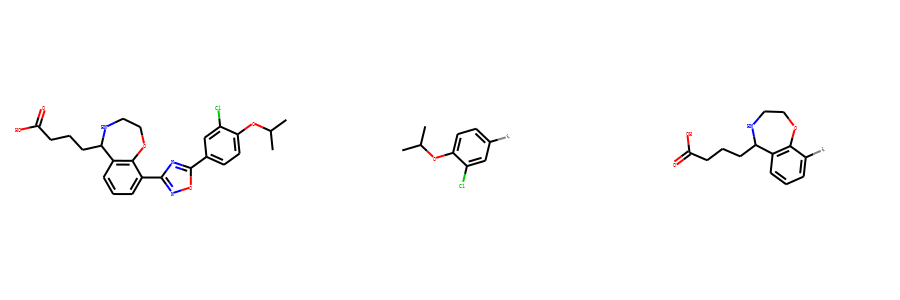

In [16]:
Chem.Draw.MolsToGridImage([ms[0], res[0], res[1]], molsPerRow=3, subImgSize=(300, 300))